# Airline Sentiment Analysis

## Table of Contents:
* [Data Collection](#DataCollection)
* [Data Wrangling](#DataWrangling)
* [EDA](#EDA)
    * [Airline Sentiment EDA](#airlineSentimentEDA)
    * [Airline EDA](#airlineEDA)
    * [Predictive Words](#pw)
    * [Predictive Words by Airline](#pwa)
    * [Date vs Airline Sentiment](#Date)
    * [User Timezone](#user_timezone)
* [Conclusion](#Conclusion) 

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#this will deal with punctuation
import string
#TOKENIZATTION
import re
#STOPWORDS
#from nltk.corpus import stopwords 
#import nltk
#LEMMATIZING
from nltk.stem import WordNetLemmatizer
from emoji import UNICODE_EMOJI
import emoji
from string import digits

import nltk #using the Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. Data Collection <a class="anchor" id="DataCollection"></a>

In [2]:
#get data
tweets = pd.read_csv("../Data/Tweets.csv")

# 2. Data Wrangling <a class="anchor" id="DataWrangling"></a>

The following needs to be done to preprocess the data:

1. Make text lowercase
2. Removing punctuations, URLs, names
3. Tokenization
4. Removing stopwords ("this", "is", etc.)
4. Lemmatizing

In [3]:
#drop columns of >= 90% null values
tweets = tweets.drop(columns=["airline_sentiment_gold" , "negativereason_gold", "tweet_coord"])

In [4]:
#Lowercase
#tweets["text"] = tweets["text"].str.lower()
#tweets["text"] = tweets["text"].apply(lambda x: x.lower())
tweets["text"] =[x.lower() for x in tweets.text]
#texts = [[word.lower() for word in text.split()] for text in data]

#remove numbers
tweets["text"] = tweets["text"].str.replace('\d+', '', regex=True)

##REMOVE PUNCTUATIONS
def remove_punc(text):
    words_wo_punct = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    return words_wo_punct

tweets["text"] = tweets["text"].apply(lambda x: remove_punc(x))

In [5]:
#REMOVE WHITESPACE
tweets["text"] = tweets["text"].str.strip()

#remove emoji
tweets["text"] = tweets["text"].apply(lambda x: emoji.demojize(x))
tweets["text"].head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercials to ...
2    virginamerica i didnt today must mean i need t...
3    virginamerica its really aggressive to blast o...
4    virginamerica and its a really big bad thing a...
Name: text, dtype: object

In [6]:
#LEMMATIZING
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    word_list = nltk.word_tokenize(text)
    lem_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lem_text

tweets["text"] = tweets["text"].apply(lambda x: word_lemmatizer(x))
tweets.text.head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercial to t...
2    virginamerica i didnt today must mean i need t...
3    virginamerica it really aggressive to blast ob...
4    virginamerica and it a really big bad thing ab...
Name: text, dtype: object

In [7]:
#REMOVE STOPWORDS and tokenize
def remove_stopwords(text):
    tokens = word_tokenize(text)
    english_stopwords = stopwords.words('english')
    tokens_wo_stopwords = [t for t in tokens if t not in english_stopwords]
    
    return tokens_wo_stopwords

tweets["text"] = tweets["text"].apply(lambda x: remove_stopwords(str(x)))
tweets["text"].head()

0                      [virginamerica, dhepburn, said]
1    [virginamerica, plus, youve, added, commercial...
2    [virginamerica, didnt, today, must, mean, need...
3    [virginamerica, really, aggressive, blast, obn...
4             [virginamerica, really, big, bad, thing]
Name: text, dtype: object

# 3. EDA <a class="anchor" id="EDA"></a>

#### View the polarity of a tweet 

In [8]:
from textblob import TextBlob, Word, Blobber
tweets['polarity']=tweets['text'].map(lambda text: TextBlob(str(text)).sentiment.polarity)
tweets.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                     0.0000  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   
3     Bad Flight                     0.7033  Virgin America    jnardino   
4     Can't Tell                     1.0000  Virgin America    jnardino   

   retweet_count                                               text  \
0              0                    [virginamerica, dhepburn, said]   
1              0  [virginamerica, plus, youve, added, commercial...   
2              0  [virginamerica, didnt, today, must, mean, need...   
3              0  [virginamerica, really, aggressive, blast, obn...   
4              0           [virginamerica, really, big, bad, thing]   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   

   polarity  
0   0.00000  
1   0.00000  
2  -0.31250  
3   0.00625  
4  -0.35000

#### View the distribution of the polarity of the tweet

Text(0.5, 1.0, 'Distibution of polarity')

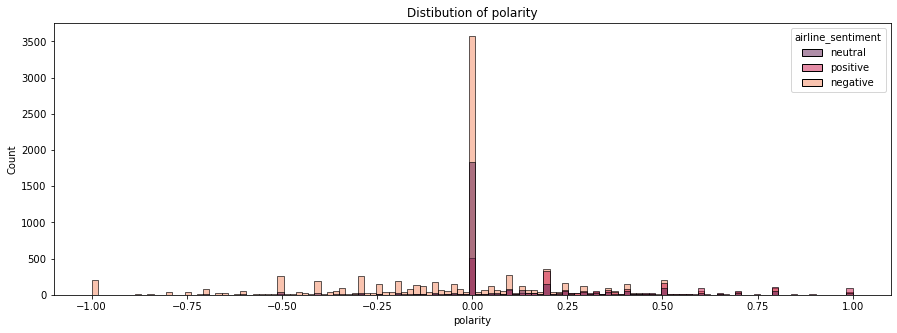

In [9]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.histplot(x = tweets["polarity"], palette="rocket", hue=tweets["airline_sentiment"])

plt.title("Distibution of polarity")

Let's look at the length of text

Text(0.5, 1.0, 'Distibution of text length')

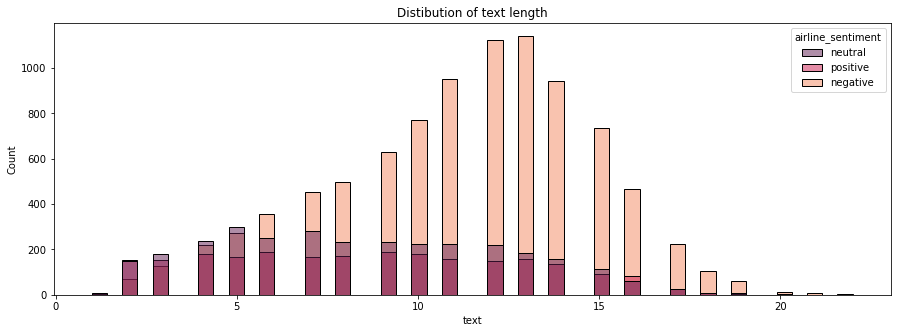

In [10]:
fig, axes = plt.subplots(figsize=(15, 5))
textLen = tweets["text"].apply(lambda x: len(x))
axes = sns.histplot(x = textLen, palette="rocket", hue=tweets["airline_sentiment"], bins=50)

plt.title("Distibution of text length")

### Word count

In [11]:
# get a word count per sentence column
def wordCount(text):
    return len(text)

tweets["word_count"] = tweets["text"].apply(lambda x: wordCount(x))

tweets.head(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                        0.0  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   

   retweet_count                                               text  \
0              0                    [virginamerica, dhepburn, said]   
1              0  [virginamerica, plus, youve, added, commercial...   
2              0  [virginamerica, didnt, today, must, mean, need...   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   

   polarity  word_count  
0    0.0000           3  
1    0.0000           7  
2   -0.3125           9

### Let's visualize this

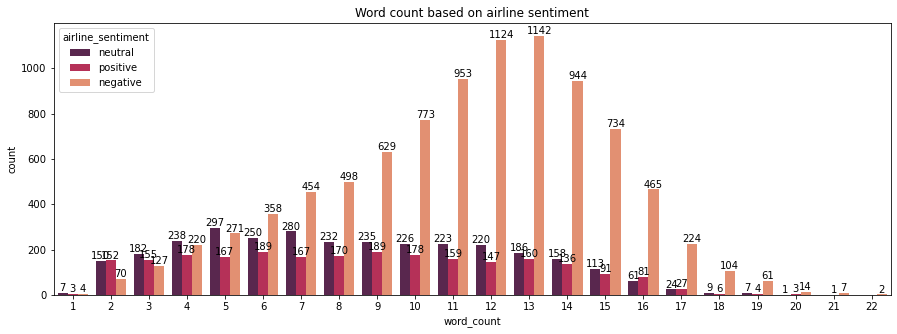

In [12]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = tweets.word_count, hue=tweets.airline_sentiment, palette="rocket")

plt.title("Word count based on airline sentiment")

for container in axes.containers:
    axes.bar_label(container)

The negative sentiment has more words in the tweet

### EDA based on airline sentiment <a class="anchor" id="airlineSentimentEDA"></a>

#### View distribution of airline_sentiment_confidence

Text(0.5, 1.0, 'Airline Sentiment Confidence Distributions')

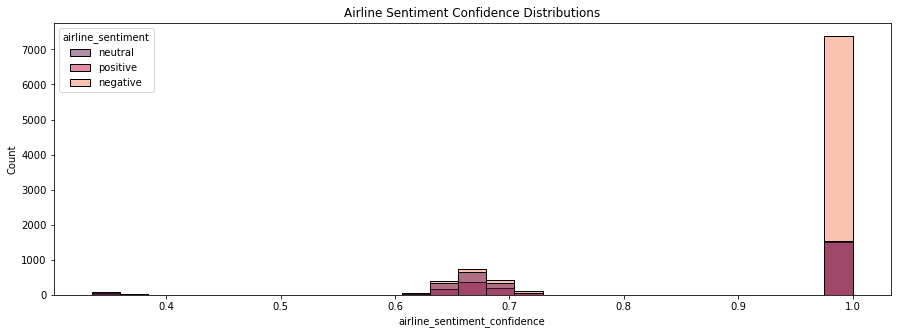

In [13]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.histplot(tweets, x="airline_sentiment_confidence", hue="airline_sentiment", palette="rocket")
plt.title("Airline Sentiment Confidence Distributions")

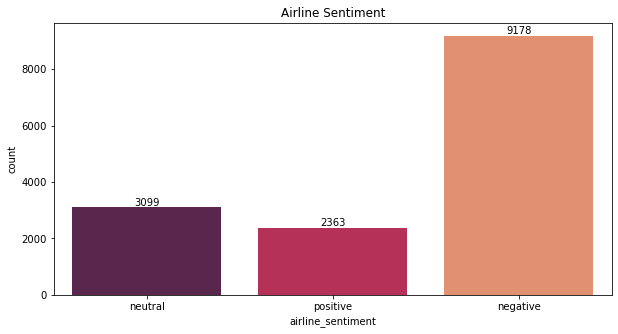

In [14]:
#see the difference between views
fig, axes = plt.subplots(figsize=(10, 5))
axes = sns.countplot(x="airline_sentiment", data=tweets, palette="rocket")
plt.title("Airline Sentiment")
for container in axes.containers:
    axes.bar_label(container)

Text(0.5, 1.0, 'Airline Sentiment Proportion')

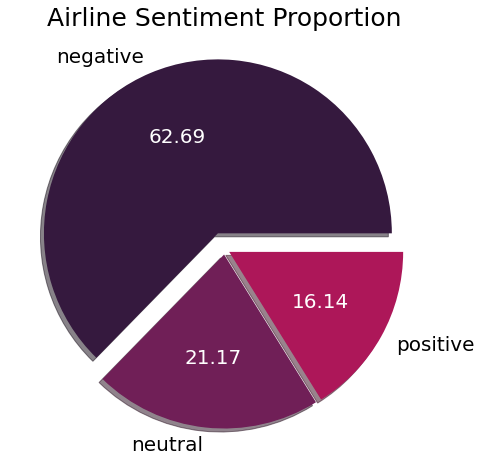

In [15]:
colors= sns.color_palette('rocket')
al = tweets["airline_sentiment"].value_counts()
myexplode = [0.10, 0.03, 0.03]

pie, ax = plt.subplots(figsize=[20,8])
_, _, autotexts = plt.pie(al, labels = al.keys(), colors=colors, autopct="%.2f", 
                          explode = myexplode, shadow=True, textprops={'fontsize': 20})

for ins in autotexts:
    ins.set_color('white')

plt.title("Airline Sentiment Proportion", fontsize=25)

### Most of the sentiment is negative.

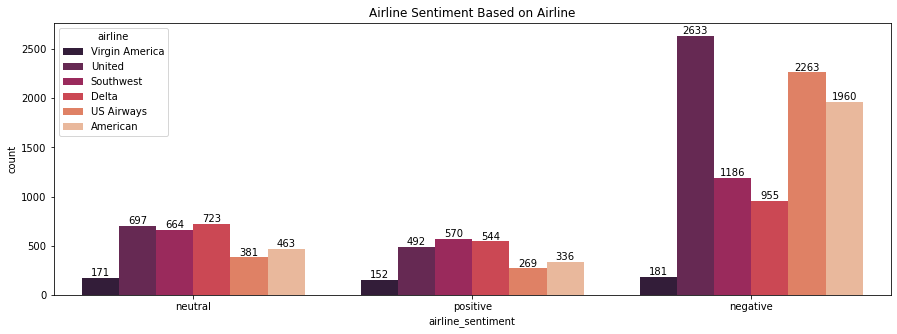

In [16]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x="airline_sentiment", hue="airline", data=tweets, palette="rocket")

plt.title("Airline Sentiment Based on Airline")
for container in axes.containers:
    axes.bar_label(container)

Text(0.5, 1.0, 'Airlines')

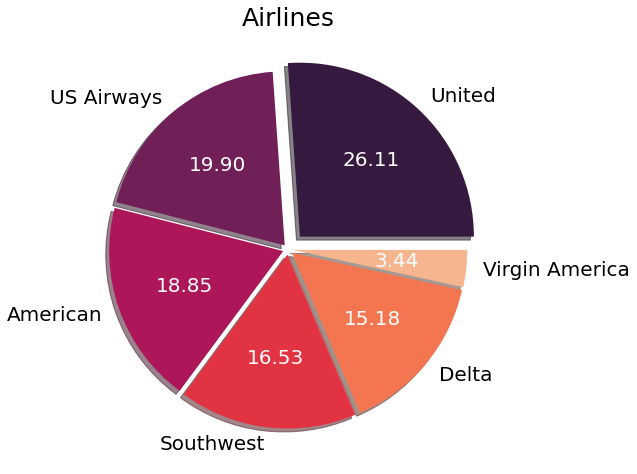

In [17]:
colors= sns.color_palette('rocket')
al = tweets["airline"].value_counts()
myexplode = [0.10, 0.03, 0.03, 0.03, 0.03, 0.03]

pie, ax = plt.subplots(figsize=[20,8])
_, _, autotexts = plt.pie(al, labels = al.keys(), colors=colors, autopct="%.2f", 
                          explode = myexplode, shadow=True, textprops={'fontsize': 20})

for ins in autotexts:
    ins.set_color('white')

plt.title("Airlines", fontsize=25)

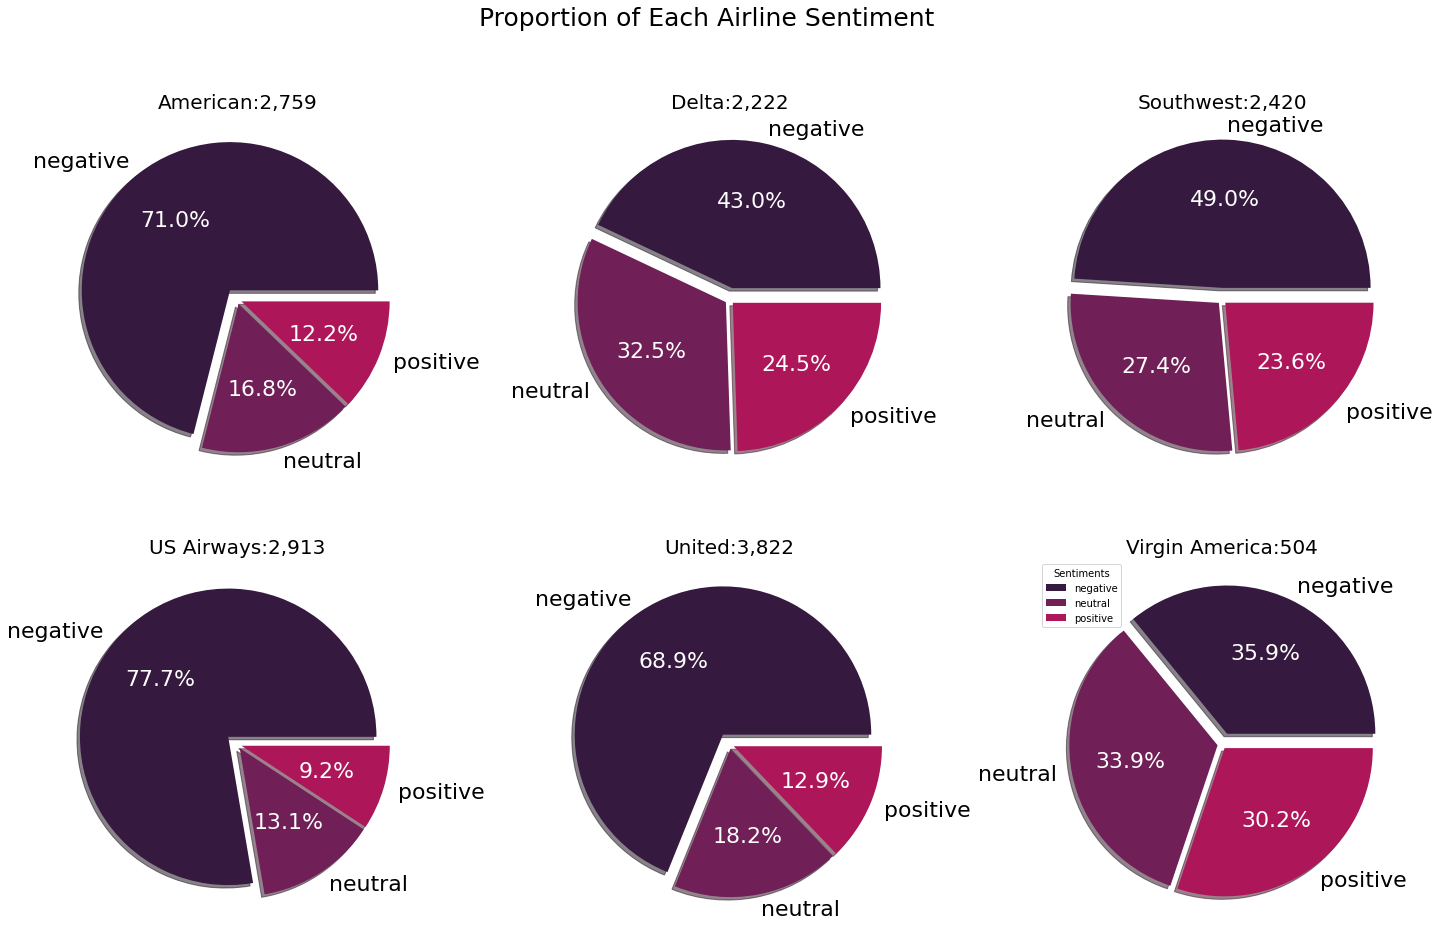

In [18]:
airlines = tweets.groupby(["airline", "airline_sentiment"])["airline_sentiment"].count().unstack()
colors= sns.color_palette('rocket')
myexplode = [0.08, 0.03, 0.03]

fig, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.flatten()

for i, ax in zip(range(0, 6), axes):
    temp = airlines.iloc[i]
    #plt.rcParams.update({'font.size': 20})
    _, _, autotexts = ax.pie(x=temp, labels = temp.index, autopct="%.1f%%", colors=colors, 
           explode = myexplode, shadow = True, textprops={'fontsize': 22})
    ax.set_title(f"{airlines.index[i]}:{format(airlines.values[i].sum(),',')}", fontsize=20)
    for ins in autotexts:
        ins.set_color('white')
    
    
    
plt.suptitle("Proportion of Each Airline Sentiment", fontsize = 25)    
plt.legend(title = "Sentiments")
plt.show()

### View the amount of retweets in the tweet

In [19]:
#get the top and lowest tweet with retweet
print("The max retweets are: " + str(max(tweets["retweet_count"])))
print("The min retweets are: " + str(min(tweets["retweet_count"])))

The max retweets are: 44
The min retweets are: 0


In [20]:
tweets.sort_values("retweet_count", ascending="False" ).head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0     570306133677760513           neutral                           1.0   
9681  569720701197750272          negative                           1.0   
9682  569719964023853056          negative                           1.0   
9683  569719741906075648          negative                           1.0   
9684  569719242427396096          negative                           1.0   

              negativereason  negativereason_confidence         airline  \
0                        NaN                        NaN  Virgin America   
9681              Can't Tell                     1.0000      US Airways   
9682  Customer Service Issue                     0.6643      US Airways   
9683             Late Flight                     1.0000      US Airways   
9684        Cancelled Flight                     0.6987      US Airways   

             name  retweet_count  \
0         cairdin              0   
9681      jamokee              0   
9682       MelCMP              0   
9683  RishiKumar8              0   
9684       MelCMP              0   

                                                   text  \
0                       [virginamerica, dhepburn, said]   
9681                                 [usairways, worst]   
9682  [usairways, making, folk, run, gate, c, b, exp...   
9683  [usairways, waiting, airplane, total, hour, ta...   
9684  [usairways, given, option, new, flight, cant, ...   

                  tweet_created           tweet_location  \
0     2015-02-24 11:35:52 -0800                      NaN   
9681  2015-02-22 20:49:34 -0800  Sandy Eggo, California    
9682  2015-02-22 20:46:38 -0800             Pennsylvania   
9683  2015-02-22 20:45:46 -0800                      NaN   
9684  2015-02-22 20:43:46 -0800             Pennsylvania   

                   user_timezone  polarity  word_count  
0     Eastern Time (US & Canada)  0.000000           3  
9681                      Alaska -1.000000           2  
9682  Eastern Time (US & Canada)  0.000000          14  
9683                       Quito -0.125000          11  
9684  Eastern Time (US & Canada) -0.431818          15

#### EDA based on airline <a class="anchor" id="airlineEDA"></a>

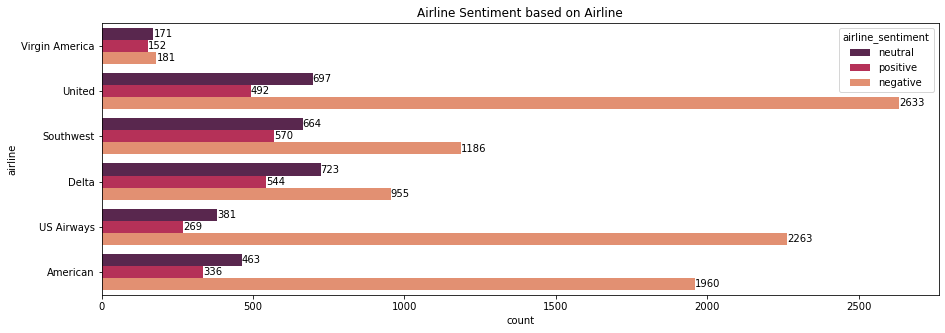

In [21]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(y="airline", hue="airline_sentiment", data=tweets, palette="rocket")
plt.title("Airline Sentiment based on Airline")

for container in axes.containers:
    axes.bar_label(container)

# <b>Get the most predictive words by airline</b> <a class="anchor" id="pw"></a>


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

tweets["text"] = tweets["text"].astype(str)

cv = CountVectorizer(min_df=50, max_df=0.70)
X = cv.fit_transform(tweets.text)
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)

lr = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)

In [23]:
words = np.array(cv.get_feature_names())

X = np.eye(X_test.shape[1])
probs = lr.predict_log_proba(X)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good Words")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad Words")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good Words
               thank 0.97
             booking 0.94
                  hi 0.94
              thanks 0.93
             amazing 0.92
               quick 0.92
              airway 0.91
             awesome 0.91
                best 0.91
                snow 0.90
Bad Words
                paid 0.27
          frustrated 0.27
              answer 0.26
               error 0.26
        unacceptable 0.25
             nothing 0.22
           complaint 0.21
          ridiculous 0.21
                fail 0.18
               worst 0.10


Method
Preprocess the text
Create term-document matrix with CountVectorizer
Train a predictive model on the matrix
Create an identity matrix the length of the vocabulary - so essentially we are creating a list of documents with the same vocabulary as our CountVectorizer, and each document is one word long - one for each word on the vocabulary
Use your model to predict on the identity matrix, and get a list of probabilities for each word
Connect the vocabulary to the probabilities (you can zip or use np.hstack or make a data frame with 2 columns)
Sort for most/least probable words for any give class
If words don’t make sense, experiment with min_df until they do (often min_df = 50 is good for this) 
you can just list these out, similarly to in the naive bayes assignment, you can also use the word_cloud module and use .generate_from_frequencies() method to create word clouds for most predictive and least predictive words
.generate_from_frequencies() allows you to input a dictionary rather than simply text, so you can input a dictionary with the words as the keys and their probabilities as the values

In [24]:
#make list of words
allWords = words[ind]
words = []

for w in allWords:
    w =  "{:>20}".format(w)
    words.append(w)

#words

#make list of prob
allProb = probs[ind]
probability = []

for p in allProb:
    p = "{:.2f}".format(1 - np.exp(p))
    probability.append(p)

#probability

In [25]:
predictiveWords = {"Words": words, "Probabilities": probability}

predictiveWords = pd.DataFrame(predictiveWords)
predictiveWords.head()

Words Probabilities
0                 thank          0.97
1               booking          0.94
2                    hi          0.94
3                thanks          0.93
4               amazing          0.92

In [26]:
#top predecticted words
predictiveWords[:10]

Words Probabilities
0                 thank          0.97
1               booking          0.94
2                    hi          0.94
3                thanks          0.93
4               amazing          0.92
5                 quick          0.92
6                airway          0.91
7               awesome          0.91
8                  best          0.91
9                  snow          0.90

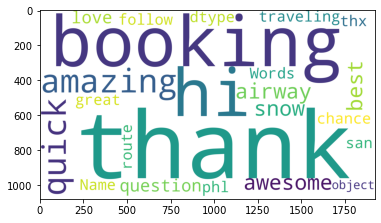

In [27]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

wc = WordCloud(background_color = 'white', width = 1920, height = 1080)
cloud = wc.generate_from_text(str(predictiveWords[:20].Words))
plt.imshow(cloud)
plt.show()

In [28]:
#bottom predecticted words
predictiveWords[-10:]

Words Probabilities
467                  paid          0.27
468            frustrated          0.27
469                answer          0.26
470                 error          0.26
471          unacceptable          0.25
472               nothing          0.22
473             complaint          0.21
474            ridiculous          0.21
475                  fail          0.18
476                 worst          0.10

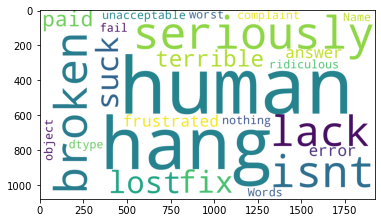

In [29]:
wc = WordCloud(background_color = 'white', width = 1920, height = 1080)
cloud = wc.generate_from_text(str(predictiveWords[-20:].Words))
plt.imshow(cloud)
plt.show()

# Changing min_df to 75

In [30]:
tweets["text"] = tweets["text"].astype(str)

cv = CountVectorizer(min_df=75, max_df=0.70)
X = cv.fit_transform(tweets.text)
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)
lr = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)


words = np.array(cv.get_feature_names())

X = np.eye(X_test.shape[1])
probs = lr.predict_log_proba(X)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good Words")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad Words")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good Words
               thank 0.96
                  hi 0.93
             booking 0.92
              thanks 0.92
              airway 0.91
             amazing 0.91
                snow 0.90
                best 0.90
             awesome 0.89
                love 0.89
Bad Words
            terrible 0.28
                paid 0.28
                suck 0.26
                isnt 0.26
              answer 0.26
        unacceptable 0.21
             nothing 0.20
          ridiculous 0.17
                fail 0.16
               worst 0.10


# Changing min_df to 100

In [31]:
tweets["text"] = tweets["text"].astype(str)

cv = CountVectorizer(min_df=100, max_df=0.70)
X = cv.fit_transform(tweets.text)
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)
lr = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)


words = np.array(cv.get_feature_names())

X = np.eye(X_test.shape[1])
probs = lr.predict_log_proba(X)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good Words")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad Words")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good Words
               thank 0.96
             booking 0.91
              thanks 0.91
                best 0.89
             awesome 0.89
               great 0.88
                love 0.88
                 thx 0.88
                 phl 0.85
              follow 0.84
Bad Words
               never 0.33
                lost 0.31
                  hr 0.31
             luggage 0.30
              system 0.29
              answer 0.27
                hour 0.27
                isnt 0.25
             nothing 0.19
               worst 0.09


# Predictive words based on Airlines <a class="anchor" id="pwa"></a>

In [32]:
def bad_good_words(df, min_df = 75):
    
    
    df["text"] = df["text"].astype(str)

    cv = CountVectorizer(min_df=min_df, max_df=0.70)
    X = cv.fit_transform(df.text)
    y = df['airline_sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)
    lr = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)


    words = np.array(cv.get_feature_names())

    X = np.eye(X_test.shape[1])
    probs = lr.predict_log_proba(X)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]

    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]

    print("Good Words")
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
    print("Bad Words")
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

## United

In [33]:
#United
df = tweets.copy()
df = df[df["airline"] == "United"]
bad_good_words(df)

Good Words
               thank 0.88
              thanks 0.80
                  dm 0.65
                good 0.64
                 got 0.62
                 way 0.61
                need 0.59
               today 0.58
               first 0.57
                last 0.56
Bad Words
               issue 0.21
               agent 0.20
                  hr 0.20
               never 0.19
              really 0.19
           cancelled 0.18
              people 0.17
                hour 0.16
             delayed 0.15
               worst 0.07


In [34]:
weirdDF =  pd.read_csv("../Data/Tweets.csv")
pd.set_option("display.max_colwidth", -1)

def getWordContext(wordList):
    #specific_words = wordList

    query = '|'.join(wordList)

    weirdDF['query_match'] = weirdDF["text"].str.contains(query, case=False)
    weirdDF['word'] = weirdDF["text"].str.extract( '({})'.format(query) )
    
    releventTweets = weirdDF[weirdDF["query_match"] == True]

    #print(releventTweets.text.head())
    return releventTweets.head()

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_24026/4025700969.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [35]:
#weirdWords = ["need", "got", "way"]
weirdWords = ["way"]
getWordContext(weirdWords)

tweet_id airline_sentiment  airline_sentiment_confidence  \
6   570300616901320704  positive          0.6745                         
13  570287408438120448  positive          0.6451                         
24  570256553502068736  negative          1.0000                         
36  570051381534396416  positive          1.0000                         
50  570009035455344640  neutral           0.6764                         

            negativereason  negativereason_confidence         airline  \
6   NaN                     0.0000                     Virgin America   
13  NaN                    NaN                         Virgin America   
24  Customer Service Issue  0.3557                     Virgin America   
36  NaN                    NaN                         Virgin America   
50  NaN                     0.0000                     Virgin America   

   airline_sentiment_gold          name negativereason_gold  retweet_count  \
6   NaN                    cjmcginnis    NaN                 0               
13  NaN                    mollanderson  NaN                 0               
24  NaN                    ayeevickiee   NaN                 0               
36  NaN                    Nicsplace     NaN                 0               
50  NaN                    grantbrowne   NaN                 0               

                                                                                                                                            text  \
6   @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)                                                                
13  @VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn   
24  @VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet    
36  @VirginAmerica Moodlighting is the only way to fly! Best experience EVER! Cool and calming. 💜✈ #MoodlitMonday                                  
50  @VirginAmerica Is flight 769 on it's way? Was supposed to take off 30 minutes ago. Website still shows "On Time" not "In Flight". Thanks.      

   tweet_coord              tweet_created    tweet_location  \
6   NaN         2015-02-24 11:13:57 -0800  San Francisco CA   
13  NaN         2015-02-24 10:21:28 -0800  NaN                
24  NaN         2015-02-24 08:18:51 -0800  714                
36  NaN         2015-02-23 18:43:35 -0800  Central Texas      
50  NaN         2015-02-23 15:55:18 -0800  Worldwide          

                  user_timezone  query_match word  
6   Pacific Time (US & Canada)   True         way  
13  Eastern Time (US & Canada)   True         way  
24  Mountain Time (US & Canada)  True         way  
36  NaN                          True         way  
50  Central Time (US & Canada)   True         way

- need > "@VirginAmerica I didn't today... Must mean I need to take another trip!" 
- got > "@VirginAmerica:You've met your match.Got status on another airline? Upgrade : http://t.co/H952rDKTqy"
- way > "@VirginAmerica Moodlighting is the only way to fly! Best experience EVER! Cool and calming."

## American

In [36]:
df = tweets.copy()
df = df[df["airline"] == "American"]
#df = tweets.loc[:, 'airline']
bad_good_words(df)

Good Words
               thank 0.94
              thanks 0.83
                 dfw 0.57
                like 0.56
            tomorrow 0.54
              change 0.52
               today 0.52
                 got 0.48
              please 0.46
                need 0.44
Bad Words
           cancelled 0.25
                  ha 0.22
                dont 0.20
                call 0.19
                 day 0.16
                 bag 0.16
                hour 0.16
            customer 0.16
                hold 0.14
                  hr 0.10


In [37]:
weirdWords = ["ha"]
getWordContext(weirdWords)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0   570306133677760513  neutral           1.0000                         
3   570301031407624196  negative          1.0000                         
5   570300767074181121  negative          1.0000                         
7   570300248553349120  neutral           0.6340                         
10  570294189143031808  neutral           0.6769                         

   negativereason  negativereason_confidence         airline  \
0   NaN           NaN                         Virgin America   
3   Bad Flight     0.7033                     Virgin America   
5   Can't Tell     0.6842                     Virgin America   
7   NaN           NaN                         Virgin America   
10  NaN            0.0000                     Virgin America   

   airline_sentiment_gold             name negativereason_gold  retweet_count  \
0   NaN                    cairdin          NaN                 0               
3   NaN                    jnardino         NaN                 0               
5   NaN                    jnardino         NaN                 0               
7   NaN                    pilot            NaN                 0               
10  NaN                    idk_but_youtube  NaN                 0               

                                                                                                                                        text  \
0   @VirginAmerica What @dhepburn said.                                                                                                        
3   @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse             
5   @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA   
7   @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP                               
10  @VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24                                            

   tweet_coord              tweet_created   tweet_location  \
0   NaN         2015-02-24 11:35:52 -0800  NaN               
3   NaN         2015-02-24 11:15:36 -0800  NaN               
5   NaN         2015-02-24 11:14:33 -0800  NaN               
7   NaN         2015-02-24 11:12:29 -0800  Los Angeles       
10  NaN         2015-02-24 10:48:24 -0800  1/1 loner squad   

                 user_timezone  query_match word  
0   Eastern Time (US & Canada)  True         ha   
3   Pacific Time (US & Canada)  True         ha   
5   Pacific Time (US & Canada)  True         ha   
7   Pacific Time (US & Canada)  True         NaN  
10  Eastern Time (US & Canada)  True         ha

 - "dfw" means Dallas/Fort Worth
 - "ha" is a part of different word

## Delta

In [38]:
df = tweets.copy()
df = df[df["airline"] == "Delta"]
bad_good_words(df)

Good Words
               thank 0.95
              thanks 0.93
               fleet 0.80
               fleek 0.65
                 guy 0.64
                 get 0.57
              flight 0.53
                  im 0.52
                 jfk 0.50
             service 0.47
Bad Words
              flight 0.53
                  im 0.52
                 jfk 0.50
             service 0.47
                  wa 0.46
                time 0.42
               plane 0.29
               delay 0.25
             delayed 0.24
                hour 0.17


In [39]:
weirdWords = ["wa", "fleek"]
getWordContext(weirdWords)

tweet_id airline_sentiment  airline_sentiment_confidence  \
6   570300616901320704  positive          0.6745                         
9   570295459631263746  positive          1.0000                         
13  570287408438120448  positive          0.6451                         
19  570267956648792064  positive          1.0000                         
21  570264145116819457  positive          1.0000                         

   negativereason  negativereason_confidence         airline  \
6   NaN            0.0                        Virgin America   
9   NaN           NaN                         Virgin America   
13  NaN           NaN                         Virgin America   
19  NaN           NaN                         Virgin America   
21  NaN           NaN                         Virgin America   

   airline_sentiment_gold          name negativereason_gold  retweet_count  \
6   NaN                    cjmcginnis    NaN                 0               
9   NaN                    YupitsTate    NaN                 0               
13  NaN                    mollanderson  NaN                 0               
19  NaN                    JNLpierce     NaN                 0               
21  NaN                    DT_Les        NaN                 0               

                                                                                                                                            text  \
6   @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)                                                                
9   @VirginAmerica it was amazing, and arrived an hour early. You're too good to me.                                                               
13  @VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn   
19  @VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.                                    
21  @VirginAmerica I love this graphic. http://t.co/UT5GrRwAaA                                                                                     

                    tweet_coord              tweet_created    tweet_location  \
6   NaN                          2015-02-24 11:13:57 -0800  San Francisco CA   
9   NaN                          2015-02-24 10:53:27 -0800  Los Angeles        
13  NaN                          2015-02-24 10:21:28 -0800  NaN                
19  NaN                          2015-02-24 09:04:10 -0800  Boston | Waltham   
21  [40.74804263, -73.99295302]  2015-02-24 08:49:01 -0800  NaN                

                 user_timezone  query_match word  
6   Pacific Time (US & Canada)  True         wa   
9   Eastern Time (US & Canada)  True         wa   
13  Eastern Time (US & Canada)  True         wa   
19  Quito                       True         wa   
21  NaN                         True         NaN

- fleek is slang for something that is good.
- "wa" is part of other words

## Southwest

In [40]:
df = tweets.copy()
df = df[df["airline"] == "Southwest"]
bad_good_words(df)

Good Words
               thank 0.95
              thanks 0.88
  destinationdragons 0.84
           southwest 0.73
              flying 0.72
                 got 0.71
                need 0.70
                know 0.69
               today 0.69
           flightled 0.67
Bad Words
                cant 0.48
                 day 0.44
               plane 0.44
                 one 0.44
            customer 0.42
               phone 0.34
           cancelled 0.32
                hour 0.22
                 bag 0.20
                hold 0.16


## US Airways

In [41]:
df = tweets.copy()
df = df[df["airline"] == "US Airways"]
bad_good_words(df)

Good Words
               thank 0.83
              thanks 0.74
              change 0.57
              please 0.56
                 amp 0.51
                 phl 0.51
         reservation 0.48
             weather 0.46
                 got 0.46
           flightled 0.42
Bad Words
              minute 0.17
                late 0.17
                  hr 0.16
                 day 0.15
           cancelled 0.14
               never 0.11
             delayed 0.11
               delay 0.08
                 min 0.06
                hour 0.06


In [42]:
weirdWords = [ "got"]
getWordContext(weirdWords)

tweet_id airline_sentiment  airline_sentiment_confidence  \
160  569564853460807680  negative          1.0000                         
173  569369239183872000  negative          1.0000                         
183  569318130356502528  positive          0.3579                         
190  569304208534597632  neutral           0.6863                         
259  568945958970531840  negative          1.0000                         

    negativereason  negativereason_confidence         airline  \
160  Late Flight    0.3571                     Virgin America   
173  Can't Tell     0.6630                     Virgin America   
183  NaN            0.0000                     Virgin America   
190  NaN           NaN                         Virgin America   
259  Bad Flight     0.6765                     Virgin America   

    airline_sentiment_gold         name negativereason_gold  retweet_count  \
160  NaN                    finslippy    NaN                 0               
173  NaN                    Boards707    NaN                 0               
183  NaN                    miaerolinea  NaN                 0               
190  NaN                    Floxie10     NaN                 0               
259  NaN                    HenryLucero  NaN                 0               

                                                                                                                                            text  \
160  @VirginAmerica got a flight (we were told) for 4:50 today..,checked my email and its for 4;50 TOMORROW. This is unacceptable.                 
173  @VirginAmerica congrats, you just got all my business from EWR to SFO/LAX. Fuck you @united fl1289 SFO/EWR was the clincher...                
183  😎 RT @VirginAmerica: You’ve met your match. Got status on another airline? Upgrade (+restr): http://t.co/RHKaMx9VF5. http://t.co/PYalebgkJt   
190  “@VirginAmerica:You've met your match.Got status on another airline? Upgrade : http://t.co/H952rDKTqy” @asarco_ES_ar ? 🙉                      
259  @VirginAmerica requested window seat and confirmed window but got stuck in middle seat. Not a good way to treat silver member😒                

    tweet_coord              tweet_created   tweet_location  \
160  NaN         2015-02-22 10:30:17 -0800  Brooklyn          
173  NaN         2015-02-21 21:32:59 -0800  Belmar, NJ        
183  NaN         2015-02-21 18:09:54 -0800  Worldwide         
190  NaN         2015-02-21 17:14:35 -0800  Argentina         
259  NaN         2015-02-20 17:31:01 -0800  Los Angeles, CA   

                  user_timezone  query_match word  
160  Eastern Time (US & Canada)  True         got  
173  Eastern Time (US & Canada)  True         got  
183  Caracas                     True         NaN  
190  NaN                         True         NaN  
259  NaN                         True         got

- "phl" stands for Philadelphia

- amp a sign for the word and (&)

## Virgin America

In [43]:
df = tweets.copy()
df = df[df["airline"] == "Virgin America"]
bad_good_words(df, min_df=5)

Good Words
                love 0.96
              thanks 0.96
                take 0.93
              second 0.93
                 new 0.92
               oscar 0.92
               great 0.92
              austin 0.92
              flying 0.91
                  lt 0.91
Bad Words
                 sad 0.54
            customer 0.54
                week 0.54
           cancelled 0.53
               never 0.52
             luggage 0.51
                seat 0.48
             nothing 0.46
             website 0.41
                site 0.40


# Lime

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

df = tweets.copy()
df = df[df["airline_sentiment"] != "neutral"]
df["text"] = df["text"].astype(str)

list_corpus = df["text"].tolist()
list_labels = df["airline_sentiment"].tolist()
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = 'english', binary=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

logreg = LogisticRegression(C=1, max_iter=1000)
logreg.fit(train_vectors, y_train)
pred = logreg.predict(test_vectors)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.901, precision = 0.897, recall = 0.901, f1 = 0.897


In [45]:
c = make_pipeline(vectorizer, logreg)
class_names=list(df.airline_sentiment.unique())
explainer = LimeTextExplainer(class_names=class_names)

idx = 187
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, labels=[1])
print('Document id: %d' % idx)
#print('Predicted class =', class_names[logreg.predict(test_vectors[idx].reshape(1,-1))])
#print('True class: %s' % class_names[y_test[idx]])

Document id: 187


In [46]:
#.reshape(1,-1)[0,0]]

In [47]:
#negative sentiment 
print ('Explanation for class %s' % class_names[1])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class negative
('thanks', 0.5618593189307274)
('helpful', 0.08884830087763239)
('ask', -0.07323786418855743)
('jfk', -0.05551448021487355)
('incredibly', -0.0510119581698863)
('jetblue', 0.0404076707468878)


In [48]:
#positive sentiment
print ('Explanation for class %s' % class_names[0])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class positive
('thanks', 0.5618593189307274)
('helpful', 0.08884830087763239)
('ask', -0.07323786418855743)
('jfk', -0.05551448021487355)
('incredibly', -0.0510119581698863)
('jetblue', 0.0404076707468878)


In [49]:
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

[1, 0]


In [50]:
exp.show_in_notebook(text=False)

It's predicting that most of the tweets are negative (90%). 

In [51]:
exp.show_in_notebook(text=y_test[idx], labels=(1,))

I zoomed in and study the explanations for class negative as well as the document itself.

### Let's look at the negative reason

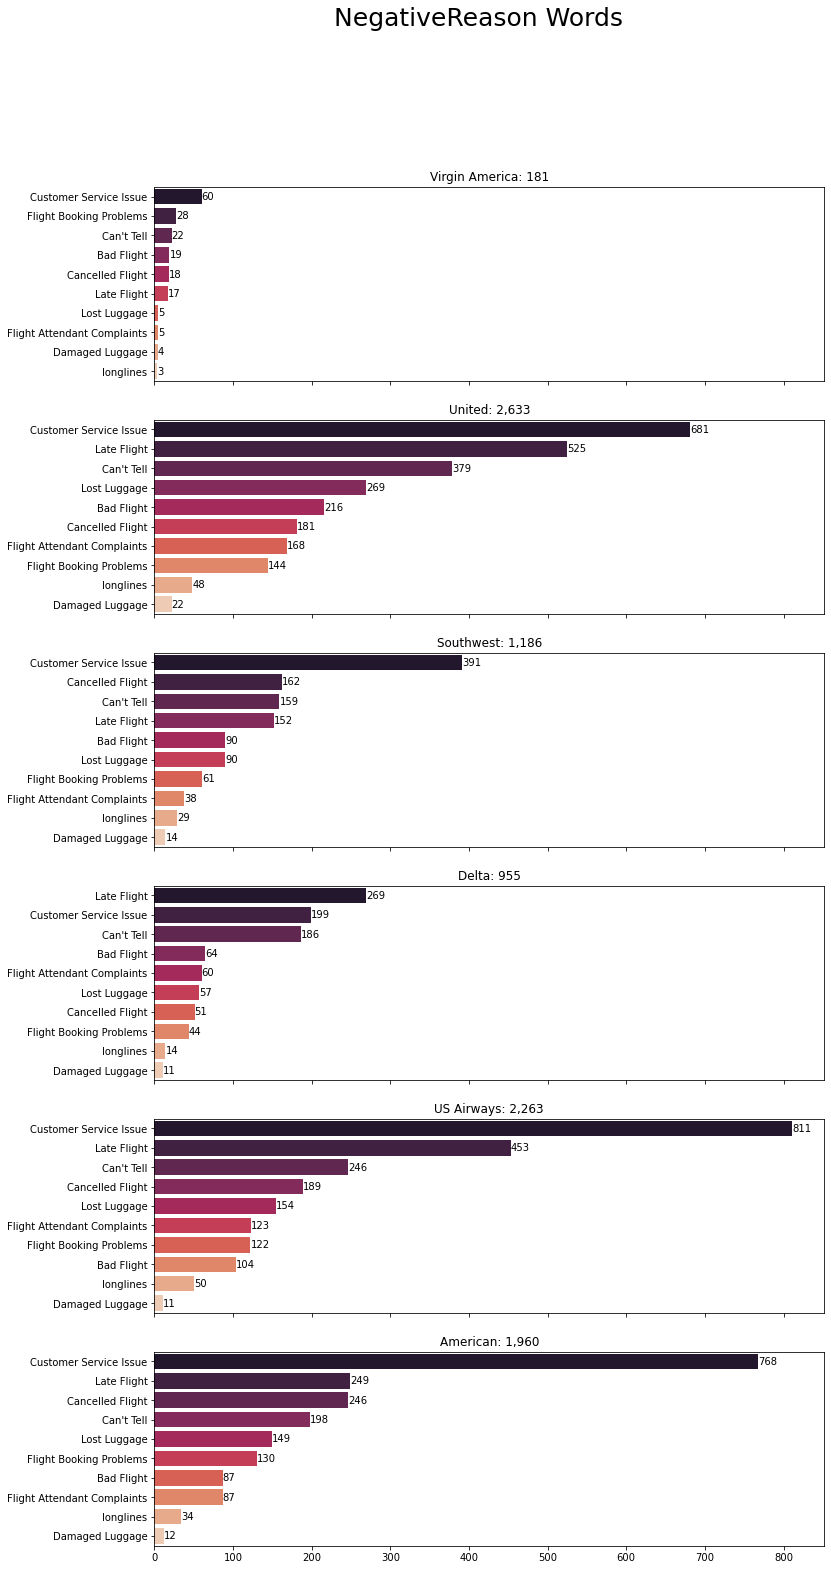

In [52]:
negDF = tweets[tweets["airline_sentiment"] == "negative"]

fig, axes = plt.subplots(6, 1, figsize=(12, 25), sharex=True)
axes = axes.flatten()
names = negDF['airline'].unique()

for name, n in zip(names, axes):
    ax = sns.countplot(data = negDF[negDF.airline==name], y = 'negativereason',
                       palette='rocket',
                       order = negDF[negDF.airline==name].negativereason.value_counts().index, ax = n)
    ax.bar_label(ax.containers[0])
    ax.set_title(f"{name}: {format(len(negDF[negDF.airline==name]),',')}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("NegativeReason Words", fontsize = 25)
plt.show()

### Date vs Airline Sentiment <a class="anchor" id="Date"></a>

In [53]:
from datetime import datetime

#convert tweet created column to datetime
tweets["tweet_created"] = pd.to_datetime(tweets["tweet_created"])

#drop timestmp 
tweets["tweet_created"] = tweets["tweet_created"].dt.date

#tweets.head(3)

# group by date , airline, and airline sentiment 
tweetGroup = tweets.groupby(["tweet_created", "airline", "airline_sentiment"]).size()
tweetGroup

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative             1  
                               neutral              1  
               United          negative             2  
2015-02-17     Delta           negative             108
                               neutral              86 
                                                    .. 
2015-02-24     United          neutral              49 
                               positive             25 
               Virgin America  negative             10 
                               neutral              6  
                               positive             13 
Length: 136, dtype: int64

The tweets are between Feb. 16, 2015 and Feb 24, 2015

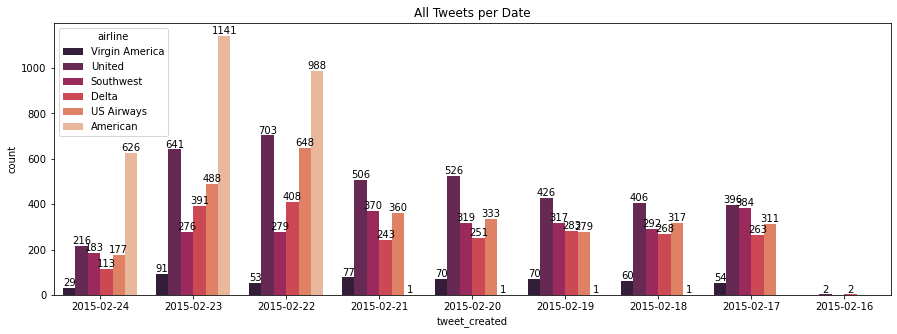

In [54]:
# All tweets per date

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "tweet_created", hue="airline", data=tweets, palette="rocket")
plt.title("All Tweets per Date")

for container in axes.containers:
    axes.bar_label(container)

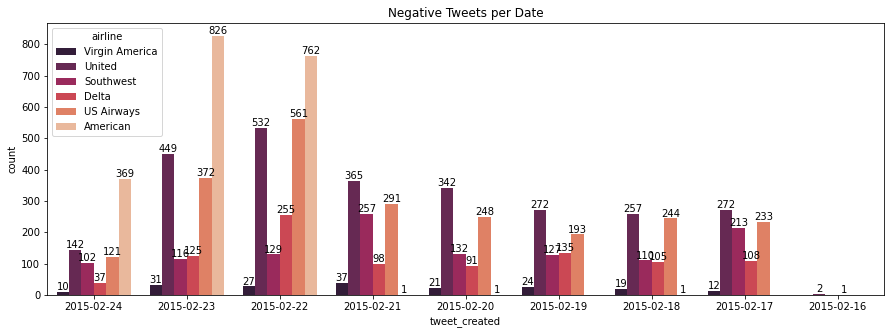

In [55]:
# Negative tweets per date

negTweets = tweets[tweets["airline_sentiment"] == 'negative']

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "tweet_created", hue="airline", data=negTweets, palette="rocket")
plt.title("Negative Tweets per Date")

for container in axes.containers:
    axes.bar_label(container)

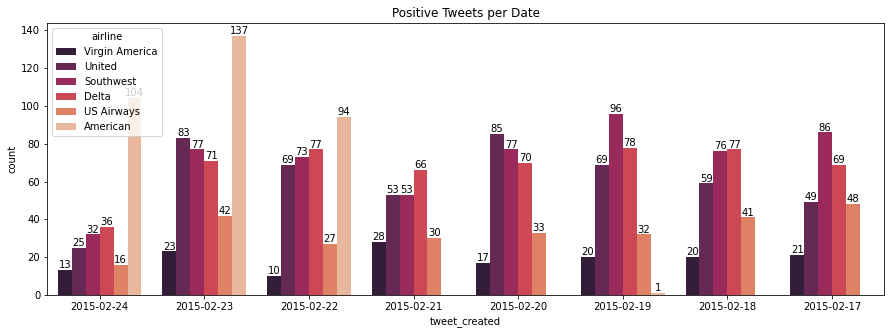

In [56]:
# Positive tweets per date

posTweets = tweets[tweets["airline_sentiment"] == 'positive']

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "tweet_created", hue="airline", data=posTweets, palette="rocket")
plt.title("Positive Tweets per Date")

for container in axes.containers:
    axes.bar_label(container)

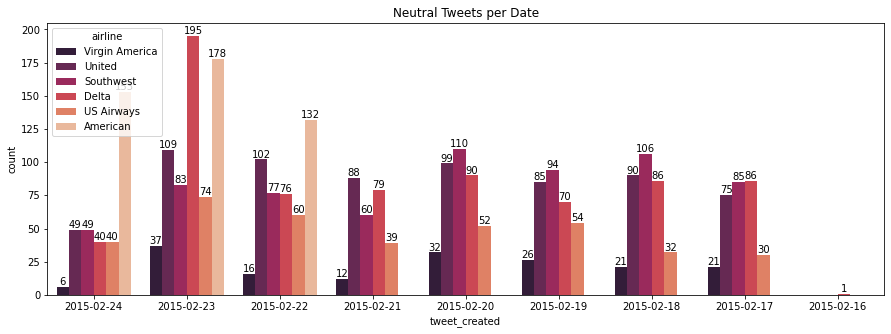

In [57]:
# Neutral tweets per date

neuTweets = tweets[tweets["airline_sentiment"] == 'neutral']

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "tweet_created", hue="airline", data=neuTweets, palette="rocket")
plt.title("Neutral Tweets per Date")

for container in axes.containers:
    axes.bar_label(container)

## user_timezone  <a class="anchor" id="user_timezone"></a>

In [58]:
#number of timezones 
tweets.user_timezone.nunique()

85

In [59]:
topTZ = tweets.user_timezone.value_counts().head(10)
topTZ = topTZ.to_frame()
topTZ = topTZ.reset_index()
topTZ = topTZ.rename(columns={"index": "Timezone", "user_timezone": "Count"})
topTZ.head()

Timezone  Count
0  Eastern Time (US & Canada)  3744 
1  Central Time (US & Canada)  1931 
2  Pacific Time (US & Canada)  1208 
3  Quito                       738  
4  Atlantic Time (Canada)      497

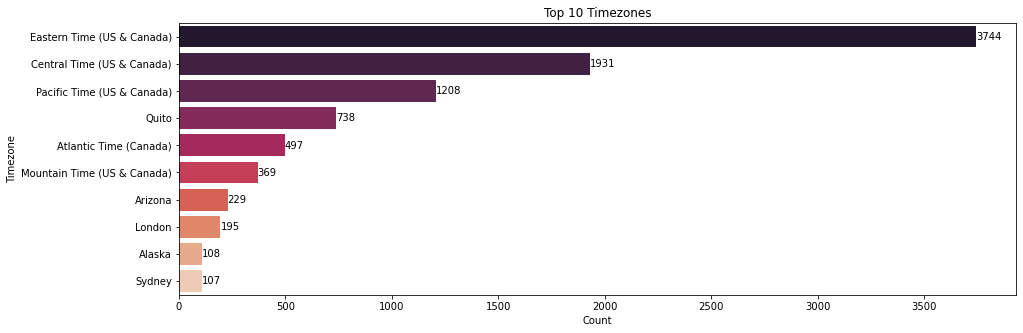

In [60]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.barplot(y = "Timezone", x="Count", data=topTZ, palette="rocket")
plt.title("Top 10 Timezones")

#plt.xticks(rotation=90)

for container in axes.containers:
    axes.bar_label(container)

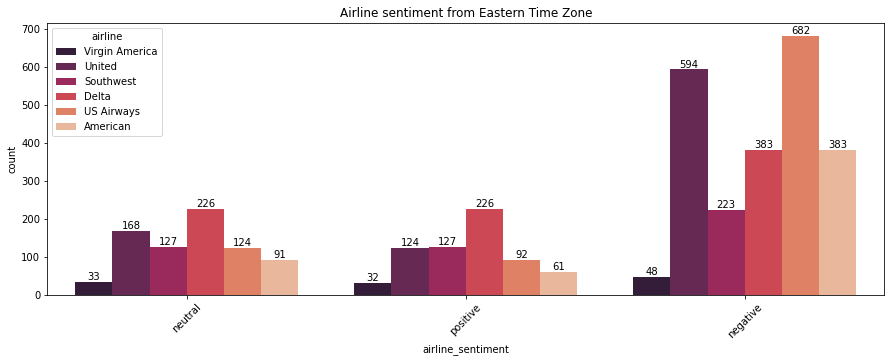

In [61]:
eastTZ = tweets[tweets["user_timezone"] == "Eastern Time (US & Canada)"]

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "airline_sentiment", hue="airline", data=eastTZ, palette="rocket")
plt.title("Airline sentiment from Eastern Time Zone")

plt.xticks(rotation=45)

for container in axes.containers:
    axes.bar_label(container)

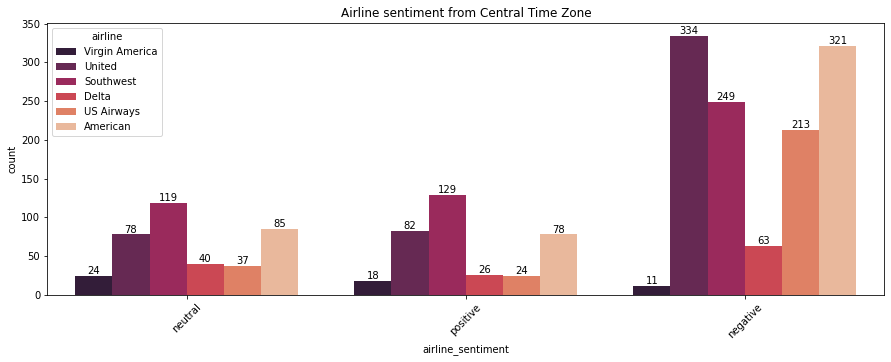

In [62]:
centralTZ = tweets[tweets["user_timezone"] == "Central Time (US & Canada)"]

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "airline_sentiment", hue="airline", data=centralTZ, palette="rocket")
plt.title("Airline sentiment from Central Time Zone")

plt.xticks(rotation=45)

for container in axes.containers:
    axes.bar_label(container)

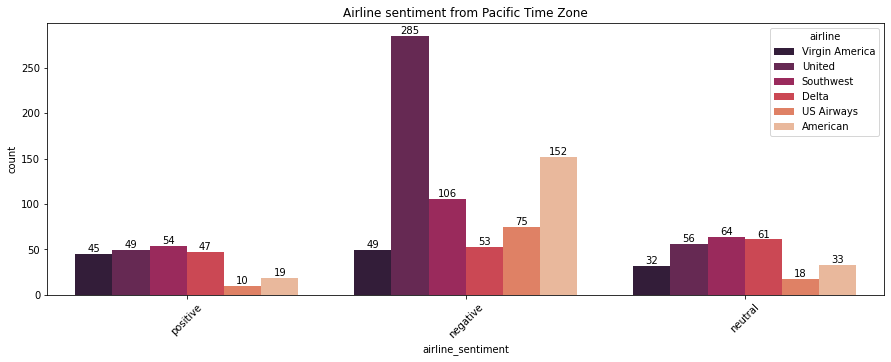

In [63]:
pacificTZ = tweets[tweets["user_timezone"] == "Pacific Time (US & Canada)"]

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "airline_sentiment", hue="airline", data=pacificTZ, palette="rocket")
plt.title("Airline sentiment from Pacific Time Zone")

plt.xticks(rotation=45)

for container in axes.containers:
    axes.bar_label(container)

# Conclusion <a class="anchor" id="Conclusion"></a>

Tracking a sentiment analysis is a way that companies can see what their customers think about their company.

Most of the the sentiment are negative.

#### Reasons for negative sentiment

Delta, American, US Airways, and United top complaints are customer service issue and late flight.

Virgin America top complaints are customer service issues and flight booking problems. 

Southwest top complaints are customer service issues and cancelled flights.